Тема: Cuped

Видео лекции:  
https://www.youtube.com/watch?v=p2WWv9Poux8
    
Видео семинара:  
https://www.youtube.com/watch?v=uyglMp0yvnE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import product

In [2]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Продолжительность пользовательских сессий.
Сгенерим синтетические данные со средней продолжительностью пользовательских сессий.

In [3]:
group_size = 100

np.random.seed(33)

df_pilot = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})
df_control = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})

Добавим столбец со средним временим сессии во время пилота. Пусть наши изменения вызвали в пилотной группе рост длины сессии на 5 минут в среднем.

In [4]:
df_pilot['y'] = df_pilot['y_before'] + np.random.normal(0, 10, group_size)
df_control['y'] = df_control['y_before'] + np.random.normal(0, 10, group_size)

df_pilot['y'] += np.random.normal(5, 2, group_size)

In [5]:
df_pilot.head()

,y_before,y
0,107.245860,117.249746
1,55.880778,64.625057
2,58.591285,54.735771
3,97.183964,105.821062
4,111.330868,117.212246


In [6]:
df_pilot.mean().round(1)

y_before    118.5
y           123.9
dtype: float64

In [7]:
df_control.mean().round(1)

y_before    114.2
y           116.1
dtype: float64

Видим, что средние стали отличаться, в пилотной группе значение больше.

Проверим значимость отличий.

In [8]:
_, pvalue_prepilot = ttest_ind(df_pilot['y_before'], df_control['y_before'])
_, pvalue_pilot = ttest_ind(df_pilot['y'], df_control['y'])
print(f'pvalue prepilot {pvalue_prepilot:0.3f}')
print(f'pvalue pilot {pvalue_pilot:0.3f}')

pvalue prepilot 0.475
pvalue pilot 0.209


Оличия не значимы, применим CUPED

In [9]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [10]:
theta = calculate_theta(
    df_control['y'], df_pilot['y'],
    df_control['y_before'], df_pilot['y_before']
)

for df_ in [df_pilot, df_control]:
    df_['y_cuped'] = df_['y'] - theta * df_['y_before']

_, pvalue_cuped = ttest_ind(df_pilot['y_cuped'], df_control['y_cuped'])
print(f'pvalue cuped {pvalue_cuped:0.3f}')

pvalue cuped 0.014


Получили значимый эффект, посмотрим как изменились дисперсии и разница средних.

In [11]:
var_y_pilot = df_pilot['y'].var()
var_y_control = df_control['y'].var()
var_y_cuped_pilot = df_pilot['y_cuped'].var()
var_y_cuped_control = df_control['y_cuped'].var()

delta_y = df_pilot['y'].mean() - df_control['y'].mean()
delta_y_cuped = df_pilot['y_cuped'].mean() - df_control['y_cuped'].mean()

print(
    f'pilot group\n    var(y) = {var_y_pilot:0.1f}\n    var(y_cuped) = {var_y_cuped_pilot:0.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_pilot/var_y_cuped_pilot:0.2f}'
)
print(
    f'control group\n    var(y) = {var_y_control:0.1f}\n    var(y_cuped) = {var_y_cuped_control:0.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_control/var_y_cuped_control:0.2f}'
)
print(f'\ndelta_y = {delta_y:0.2f}\ndelta_y_cuped = {delta_y_cuped:0.2f}')

pilot group
    var(y) = 1842.7
    var(y_cuped) = 101.6
    var(y)/var(y_cuped) = 18.14
control group
    var(y) = 1920.2
    var(y_cuped) = 86.6
    var(y)/var(y_cuped) = 22.16

delta_y = 7.73
delta_y_cuped = 3.41


Дисперсия упала примерно в 20 раз.

### Как влияет $\theta$ на уменьшение дисперсии
Посмотрим какое значение $theta$ мы получили по теоретической формуле. Посмотрим как меняется дисперсия при других значениях.

In [12]:
theta

1.020854881287663

In [13]:
thetas = np.linspace(0.5, 1.5, 101)

list_var_y_cuped_pilot = []
list_var_y_cuped_control = []
for theta_ in thetas:
    for df_ in [df_pilot, df_control]:
        df_['y_cuped_'] = df_['y'] - theta_ * df_['y_before']
    var_y_cuped_pilot = df_pilot['y_cuped_'].var()
    var_y_cuped_control = df_control['y_cuped_'].var()
    list_var_y_cuped_pilot.append(var_y_cuped_pilot)
    list_var_y_cuped_control.append(var_y_cuped_control)


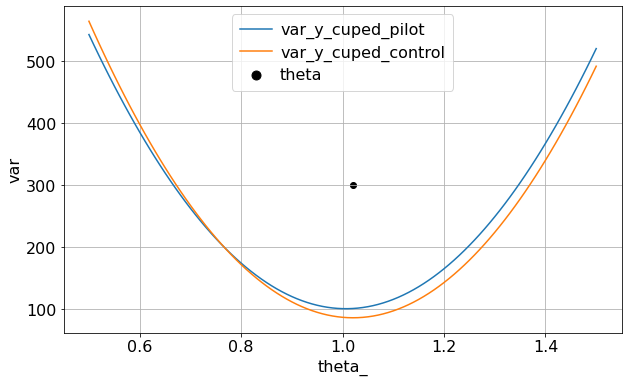

In [14]:
plt.plot(thetas, list_var_y_cuped_pilot, label='var_y_cuped_pilot')
plt.plot(thetas, list_var_y_cuped_control, label='var_y_cuped_control')
plt.scatter([theta], [300], label='theta', c='k')
plt.xlabel('theta_')
plt.ylabel('var')
plt.grid()
plt.legend()
plt.show()

Видно, что $\theta$ подобрана достаточно оптимально.

# 2. Продажа минералки
Пилот направлен на увеличение продажи минеральной воды. Продажа минеральной воды зависит от температуры воздуха на улице, чем жарче, тем продажи больше.

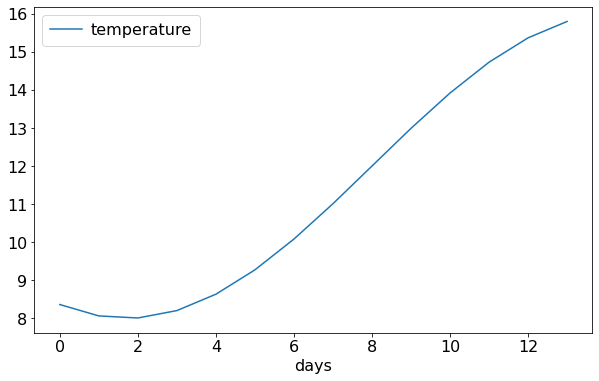

In [15]:
days = np.arange(14)
temperature = (np.sin((days - 8)/4) + 3) * 4
plt.plot(days, temperature, label='temperature')
plt.legend()
plt.xlabel('days')
plt.show()

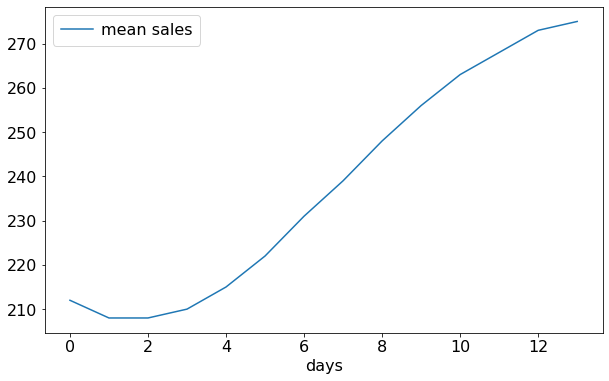

In [16]:
mean_sales = (np.log(temperature) * 100).astype(int)
plt.plot(days, mean_sales, label='mean sales')
plt.legend()
plt.xlabel('days')
plt.show()

Пилот проводился во вторые 7 дней. У нас есть данные из 10 магазинов: 5 контрольных и 5 пилотных.

In [17]:
np.random.seed(44)

df_mean_sales = pd.DataFrame({'day': days, 'temperature': temperature.round(1), 'mean_sales': mean_sales})

shops = np.arange(10)
df = pd.DataFrame(product(days, shops), columns=('day', 'shop'))
df['pilot'] = (df['shop'] < 5).astype(int)
df = pd.merge(df, df_mean_sales, on='day')

df['y'] = df['mean_sales'] + np.random.normal(0, 10, len(df)).astype(int)

# добавим эффект
mask_pilot = (df['pilot'] == 1) & (df['day'] >= 7)
df.loc[mask_pilot, 'y'] += np.random.normal(9, 10, mask_pilot.sum()).astype(int)

df.sample(5)

,day,shop,pilot,temperature,mean_sales,y
16,1,6,0,8.1,208,218
81,8,1,1,12.0,248,249
131,13,1,1,15.8,275,288
87,8,7,0,12.0,248,260
38,3,8,0,8.2,210,207


Посмотрим как менялись продажи в магазинах пилотной и контрольной групп

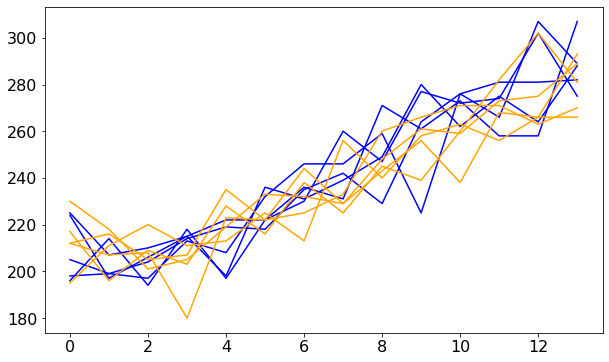

In [18]:
for shop, df_ in df.groupby('shop'):
    df_ = df_.sort_values('day')
    color = 'blue' if shop < 5 else 'orange'
    plt.plot(df_['day'].values, df_['y'].values, c=color)
plt.show()

Если смотреть на магазины по отдельности, то сложно увидеть эффект, посмотрим на среднее в группах.

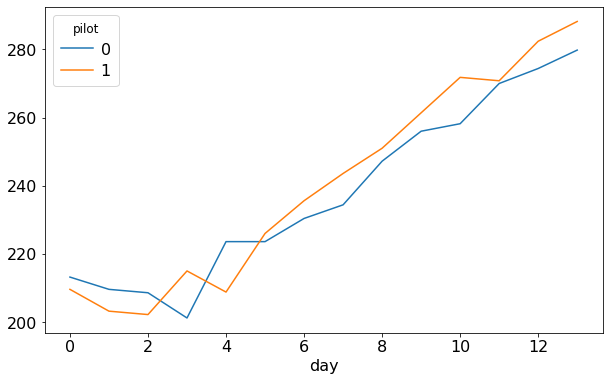

In [19]:
(
    df
    .groupby(['pilot', 'day'])[['y']].mean()
    .reset_index()
    .pivot(columns='pilot', index='day', values='y')
    .plot()
)
plt.show()

Среднее пилотной группы во время пилота, как правило, чуть больше среднего контрольной группы.

Проверим статзначимость

In [20]:
index_pilot = df[(df['pilot'] == 1) & (df['day'] >= 7)].sort_values(['shop', 'day']).index.values
index_control = df[(df['pilot'] == 0) & (df['day'] >= 7)].sort_values(['shop', 'day']).index.values
index_pilot_before = df[(df['pilot'] == 1) & (df['day'] < 7)].sort_values(['shop', 'day']).index.values
index_control_before = df[(df['pilot'] == 0) & (df['day'] < 7)].sort_values(['shop', 'day']).index.values


delta_y = df.loc[index_pilot, 'y'].mean() - df.loc[index_control, 'y'].mean()
_, pvalue = ttest_ind(df.loc[index_pilot, 'y'], df.loc[index_control, 'y'])
print(f'delta_y = {delta_y:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y = 7.03
pvalue = 0.13


Во время пилота продажи в среднем болше на 7.03, но это не статзначимо, pvalue > 0.05.

#### Попробуем применить CUPED

In [21]:
theta = calculate_theta(
    df.loc[index_control, 'y'], df.loc[index_pilot, 'y'],
    df.loc[index_control_before, 'y'], df.loc[index_pilot_before, 'y']
)

y_cuped_pilot = df.loc[index_pilot, 'y'].values - theta * df.loc[index_pilot_before, 'y'].values
y_cuped_control = df.loc[index_control, 'y'].values - theta * df.loc[index_control_before, 'y'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y_cuped = 7.67
pvalue = 0.08


Нулевая гипотеза опять не отвергается, посмотрим как изменилась дисперсия

In [22]:
np.var(y_cuped_pilot), np.var(df.loc[index_pilot, 'y'].values)

(342.8339791134314, 402.42775510204086)

Дисперсия снизилась, но не столь сильно.

Что ещё можно попровать?

.

.

.

.

.

.

Можно взять в качестве коварианты температуру воздуха на улице

In [23]:
theta = calculate_theta(
    df.loc[index_control, 'y'], df.loc[index_pilot, 'y'],
    df.loc[index_control, 'temperature'], df.loc[index_pilot, 'temperature']
)

y_cuped_pilot = df.loc[index_pilot, 'y'].values - theta * df.loc[index_pilot, 'temperature'].values
y_cuped_control = df.loc[index_control, 'y'].values - theta * df.loc[index_control, 'temperature'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y_cuped = 7.03
pvalue = 0.02


In [24]:
np.var(y_cuped_pilot), np.var(df.loc[index_pilot, 'y'].values)

(185.87663284484682, 402.42775510204086)

Статзначимые отличия получены! Дисперсия уменьшилась более чем в два раза.

# 3. CUPED + ML
Возьмем набор данных, который содержит информацию о различных домах в Бостоне.

In [25]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

In [26]:
print(boston_dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Построим распределение целевой переменной.

In [27]:
X = pd.DataFrame(boston_dataset['data'], columns=boston_dataset['feature_names'])
y = boston_dataset['target']
X['history'] = boston_dataset['target'] * np.random.normal(1, 0.3, boston_dataset['target'].shape[0])

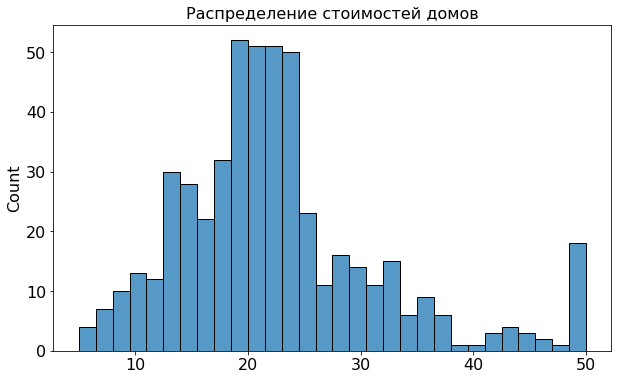

In [28]:
sns.histplot(y, bins=30)
plt.title('Распределение стоимостей домов')
plt.show()

Хотим протестировать влияние новых маркетинговых хитростей на стоимость продажи дома.

Выберем две группы и сравним значимость отличия стоимостей домов в этих группах.

In [29]:
np.random.seed(24)

group_size = 100

indexes = np.random.choice(np.arange(len(y)), group_size * 2, False)
a_indexes = indexes[:group_size]
b_indexes = indexes[group_size:]

a_y = y[a_indexes]
b_y = y[b_indexes]

print(f'mean(b_y) - mean(a_y) = {np.mean(b_y) - np.mean(a_y):0.2f}')
print(f'pvalue = {ttest_ind(a_y, b_y)[1]:0.3f}')

mean(b_y) - mean(a_y) = 0.18
pvalue = 0.889


## 3.1. Добавим эффект
Добавим искусственно эффект в группу B. Посмотрим есть ли эффект

In [30]:
np.random.seed(33)

b_y_effect = b_y + np.random.normal(1.5, 2, len(b_y))
# b_y_effect = b_y + np.random.normal(0, 1, len(b_y))

print(f'mean(b_y_effect) - mean(a_y) = {np.mean(b_y_effect) - np.mean(a_y):0.2f}')
print(f'pvalue = {ttest_ind(a_y, b_y_effect)[1]:0.3f}')

mean(b_y_effect) - mean(a_y) = 1.60
pvalue = 0.231


Значимого эффекта нет.

Допустим, знаем стоимость продажи некоторых других домов. Попробуем обучить модель прогнозирования стоимости продажи дома и использовать предсказание стоимости как коварианту для CUPED.

## 3.2. Изучение признаков и обучение модели

In [31]:
other_indexes = np.array(list(
    set(np.arange(len(y))) - set(np.hstack([a_indexes, b_indexes]))
))
other_y = y[other_indexes]

a_X = X.iloc[a_indexes]
b_X = X.iloc[b_indexes]
other_X = X.iloc[other_indexes]

print(f'количество данных для обучения: {len(other_y)}')

количество данных для обучения: 306


Посмотрим на корреляции

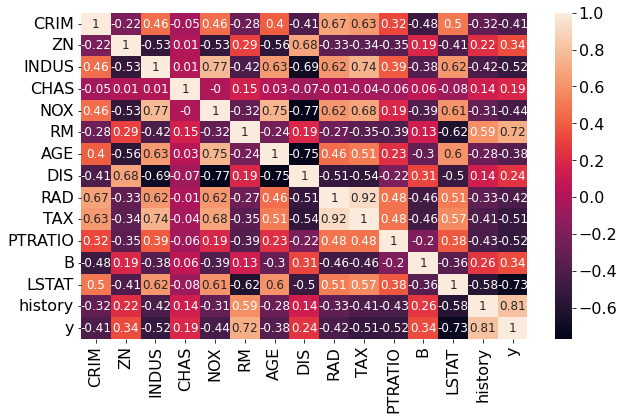

In [32]:
other_X_y = other_X.copy()
other_X_y['y'] = other_y

correlation_matrix = other_X_y.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Наибольшие корреляции таргета с признаками RM и LSTAT.

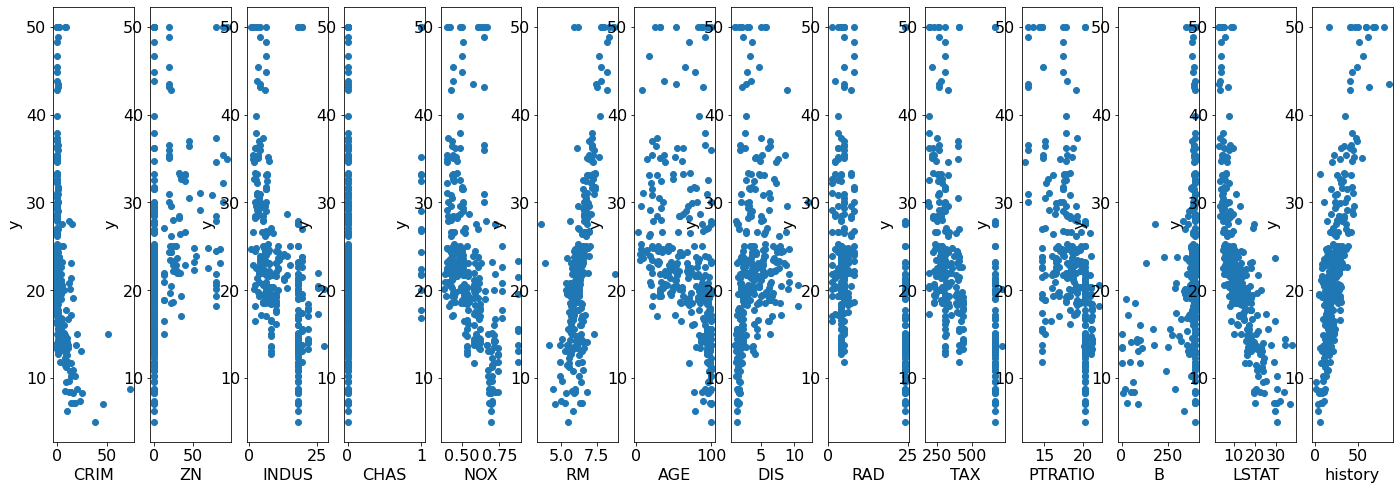

In [33]:
features = ['LSTAT', 'RM']
features = other_X.columns

fig = plt.figure(figsize=[24, 8])
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i+1)
    # plt.subplot(2, len(features) // 2, i+1)
    x = other_X[feature]
    plt.scatter(x, other_y, marker='o')
    plt.xlabel(feature)
    plt.ylabel('y')

Обучим модель. Сравним качество предсказание модели для группы А с наивным прогнозом = средняя стоимость 

In [34]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [35]:
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = RidgeCV(alphas=alphas, normalize=True, store_cv_values=True)

model.fit(other_X[features], other_y)

a_predict = model.predict(a_X[features])
a_predict_naive = np.zeros(len(a_y)) + np.mean(other_y)

print(f'MSE model predict: {mean_squared_error(a_y, a_predict):0.1f}')
print(f'MSE naive predict: {mean_squared_error(a_y, a_predict_naive):0.1f}')

MSE model predict: 18.9
MSE naive predict: 68.0


Видим, что качество предсказание модели лучше безлайна.

Посмотрим на корреляцию предикта и таргета.

In [36]:
print(f'corr(a_y, a_predict) = {np.corrcoef(a_y, a_predict)[0, 1]:0.3f}')

corr(a_y, a_predict) = 0.848


Корреляция довольно большая. Применим CUPED.

## 3.3. CUPED на предсказаниях модели

In [37]:
b_predict = model.predict(b_X[features])

In [38]:
theta = calculate_theta(
    a_y, b_y_effect,
    a_predict, b_predict
)

y_cuped_pilot = b_y_effect - theta * b_predict
y_cuped_control = a_y - theta * a_predict

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.3f}')

delta_y_cuped = 1.00
pvalue = 0.104


In [39]:
from scipy.stats import norm, ttest_ind
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

get_minimal_determinable_effect(a_y.std(), a_y.shape[0]), get_minimal_determinable_effect(y_cuped_control.std(), y_cuped_control.shape[0])

(3.2428942249405273, 1.7949515589133402)

Получили стат значимые отличия!

In [40]:
yy = np.hstack([y_cuped_pilot, y_cuped_control])

rr = []

for _ in range(1000):
  np.random.shuffle(yy)
  a_ = yy[:100]
  b_ = yy[100:]
  _, pvalue = ttest_ind(a_, b_)
  rr.append(pvalue)

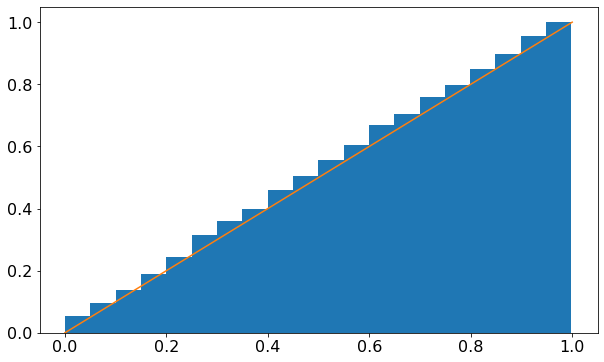

In [41]:
plt.hist(rr, bins=20, cumulative=True, density=True)
plt.plot([0,1], [0,1]);

Данные изменения проводились только для семинара, по сути множественное тестирование. В жизни стоит фиксировать дизайн эксперимента и алгоритм принятия решения до начала эксперимента